In [8]:
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m2/4 [pandas]
Note: you may need to restart the kernel to use updated packages.


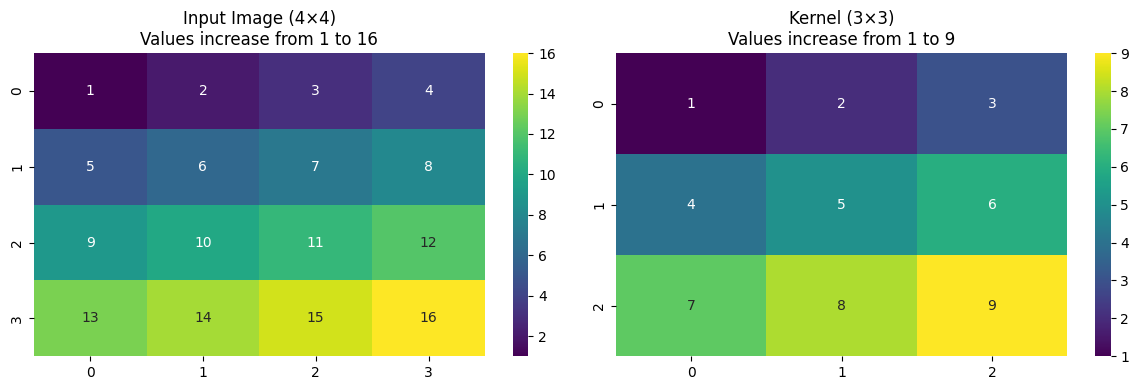

Matrix multiplications for each output position:

Output position (0,0):
Input patch:
tensor([[ 1.,  2.,  3.],
        [ 5.,  6.,  7.],
        [ 9., 10., 11.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[ 1.,  4.,  9.],
        [20., 30., 42.],
        [63., 80., 99.]])
Sum (output value): 348.0

Output position (0,1):
Input patch:
tensor([[ 2.,  3.,  4.],
        [ 6.,  7.,  8.],
        [10., 11., 12.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[  2.,   6.,  12.],
        [ 24.,  35.,  48.],
        [ 70.,  88., 108.]])
Sum (output value): 393.0

Output position (1,0):
Input patch:
tensor([[ 5.,  6.,  7.],
        [ 9., 10., 11.],
        [13., 14., 15.]])

Kernel:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Element-wise multiplication:
tensor([[  5.,  12.,  21.],
        [ 36.,  50.,  66.],
        [ 91., 112., 135.

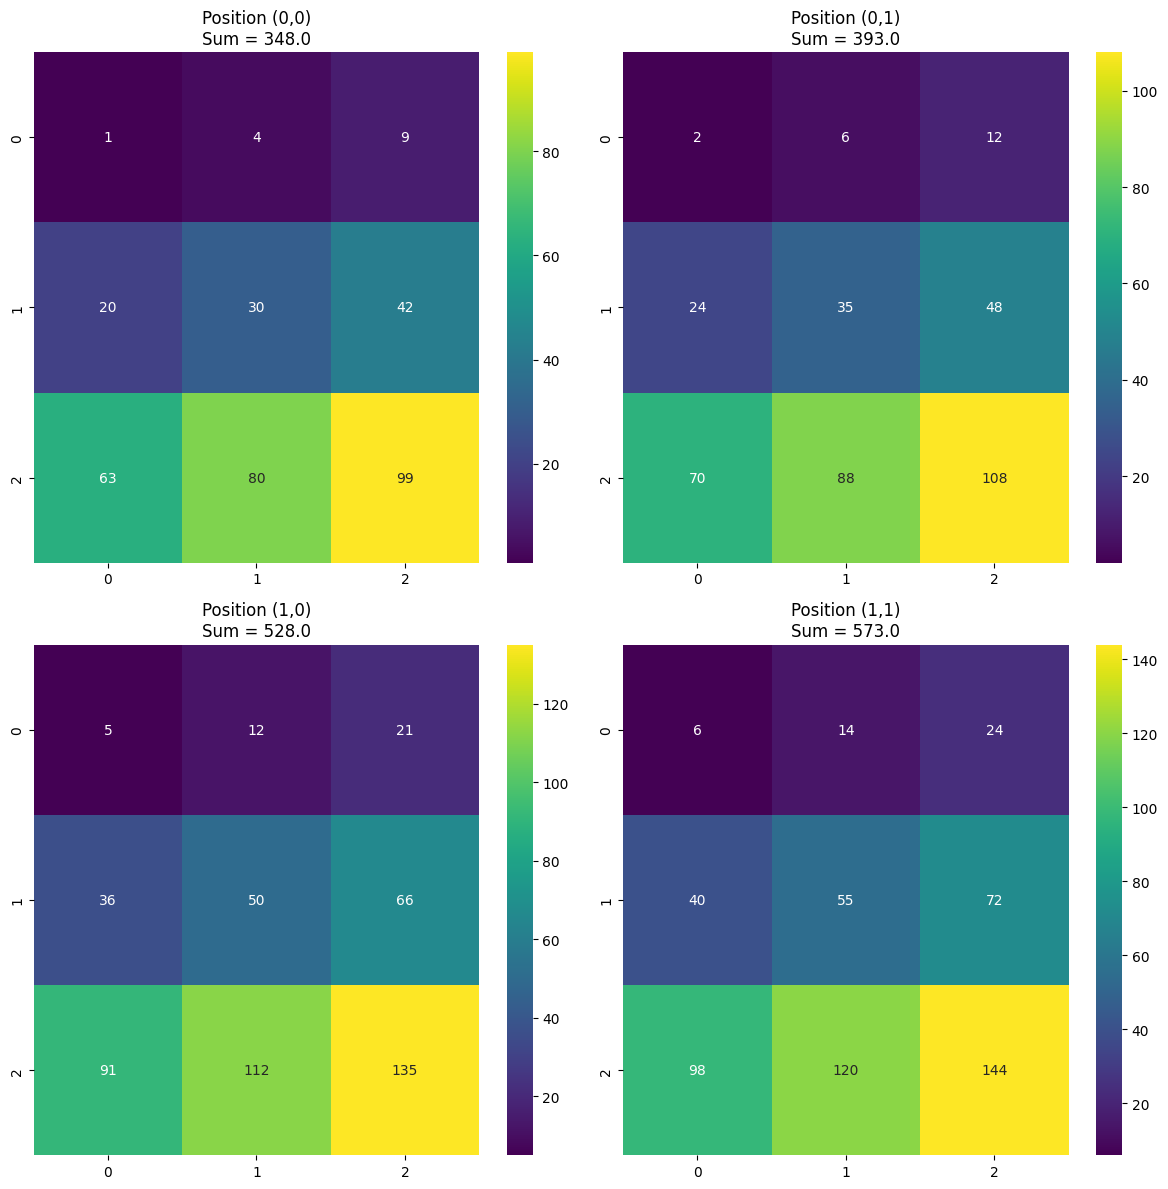


PyTorch output:
 tensor([[348., 393.],
        [528., 573.]])


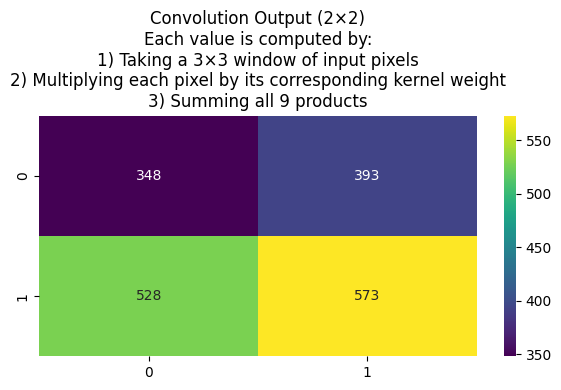

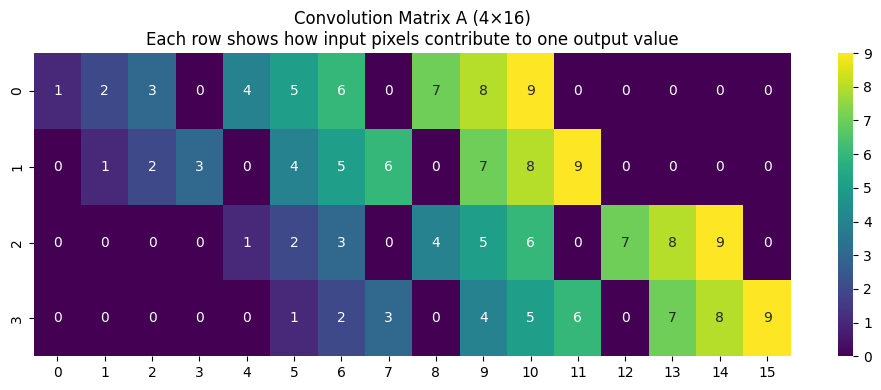


Convolution matrix A (rows = outputs, cols = input pixels):

tensor([[1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0.],
        [0., 0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9.]])


In [15]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1) "Image"  (4 × 4)   and   Kernel  (3 × 3)
# This is a 4x4 input image tensor where values increase sequentially from 1 to 16
# Each number represents a pixel intensity value in the input image
# The values increase from top-left (1) to bottom-right (16)
v_img = torch.tensor([[1,  2,  3,  4],
                      [5,  6,  7,  8],
                      [9, 10, 11, 12],
                      [13,14, 15, 16]], dtype=torch.float32)

# This kernel represents a 3x3 filter where values increase from 1 to 9
# Each number represents a weight that will be multiplied with corresponding input pixels
# The pattern shows increasing values from top-left (1) to bottom-right (9)
kernel = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]], dtype=torch.float32)

# Visualize input image and kernel
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.heatmap(v_img.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Input Image (4×4)\nValues increase from 1 to 16')
plt.subplot(122)
sns.heatmap(kernel.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Kernel (3×3)\nValues increase from 1 to 9')
plt.tight_layout()
plt.show()

# Reshape input image to (batch, channels, height, width) format
# Reshape kernel to (out_channels, in_channels, height, width) format
v_bchw = v_img.unsqueeze(0).unsqueeze(0)      # (1,1,4,4)
w_oihw = kernel.unsqueeze(0).unsqueeze(0)     # (1,1,3,3)

# Print and visualize the matrix multiplications for each output position
print("Matrix multiplications for each output position:")
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    # Get the 3x3 patch of input image
    patch = v_img[i:i+3, j:j+3]
    
    # Print the multiplication
    print(f"\nOutput position ({i},{j}):")
    print("Input patch:")
    print(patch)
    print("\nKernel:")
    print(kernel)
    print("\nElement-wise multiplication:")
    mult = patch * kernel
    print(mult)
    print(f"Sum (output value): {torch.sum(mult)}")
    
    # Visualize the multiplication
    ax = axes[idx]
    sns.heatmap(mult.numpy(), annot=True, cmap='viridis', fmt='.0f', ax=ax)
    ax.set_title(f'Position ({i},{j})\nSum = {torch.sum(mult)}')

plt.tight_layout()
plt.show()

y_torch = F.conv2d(v_bchw, w_oihw, stride=1, padding=0)  # (1,1,2,2)
print("\nPyTorch output:\n", y_torch.squeeze())

# Visualize the 2x2 output matrix from the convolution operation
# Each value represents the result of applying the 3x3 kernel to a 3x3 patch of the input image
plt.figure(figsize=(6, 4))
sns.heatmap(y_torch.squeeze().numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Convolution Output (2×2)\nEach value is computed by:\n1) Taking a 3×3 window of input pixels\n2) Multiplying each pixel by its corresponding kernel weight\n3) Summing all 9 products')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) Build the explicit convolution matrix A  (4 × 16)
H, W = 4, 4          # Input image dimensions
out_h, out_w = 2, 2  # Output dimensions after convolution
A = torch.zeros(out_h * out_w, H * W)  # Create empty matrix (4×16)

# For each input pixel position p:
for p in range(H * W):
    delta = torch.zeros_like(v_bchw)
    r, c = divmod(p, W)  # Convert linear index to row,col coordinates
    delta[0, 0, r, c] = 1.0  # Set the single 1.0 at position (r,c)
    A[:, p] = F.conv2d(delta, w_oihw).flatten()

# Verify matrix representation
v_flat = v_img.flatten()  # Flatten input image to vector
y_from_A = A @ v_flat     # Matrix multiplication
assert torch.allclose(y_from_A, y_torch.flatten())  # Should match direct convolution result

# Visualize convolution matrix A
plt.figure(figsize=(10, 4))
sns.heatmap(A.numpy(), annot=True, cmap='viridis', fmt='.0f')
plt.title('Convolution Matrix A (4×16)\nEach row shows how input pixels contribute to one output value')
plt.tight_layout()
plt.show()

print("\nConvolution matrix A (rows = outputs, cols = input pixels):\n")
print(A)

In [3]:
import numpy as np

# -------------------------------------------------------------
# Helpers
# -------------------------------------------------------------
def conv2d_single_gray(im, ker, padding=0):
    """Single-channel 2-D convolution with zero-padding, stride = 1."""
    kH, kW = ker.shape
    H,  W  = im.shape
    # pad image
    im_p = np.pad(im, ((padding, padding), (padding, padding)), mode='constant')
    out_h, out_w = H, W  # because stride=1 and padding chosen so that output = input size
    out = np.zeros((out_h, out_w), dtype=im.dtype)
    for i in range(out_h):
        for j in range(out_w):
            patch = im_p[i:i+kH, j:j+kW]
            out[i, j] = np.sum(patch * ker)
    return out

def conv2d_rgb(im, ker, padding=0):
    """
    im : (C, H, W)
    ker: (C, kH, kW) -- single output channel, C input channels
    returns (H, W)
    """
    C, H, W   = im.shape
    kC, kH, kW = ker.shape
    assert C == kC
    im_p = np.pad(im, ((0,0), (padding, padding), (padding, padding)), mode='constant')
    out = np.zeros((H, W), dtype=im.dtype)
    for i in range(H):
        for j in range(W):
            patch = im_p[:, i:i+kH, j:j+kW]   # (C, kH, kW)
            out[i, j] = np.sum(patch * ker)
    return out

# -------------------------------------------------------------
# 1) Grayscale example with padding = 1
# -------------------------------------------------------------
v_img = np.array([[1,  2,  3,  4],
                  [5,  6,  7,  8],
                  [9, 10, 11, 12],
                  [13,14, 15, 16]], dtype=np.float32)

kernel_gray = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]], dtype=np.float32)

H, W = v_img.shape
out_gray = conv2d_single_gray(v_img, kernel_gray, padding=1)
print("➡️  Grayscale conv (padding=1) output shape:", out_gray.shape)
print(out_gray)
print()

# Build A (16 × 16)
num_out = H * W
num_in  = H * W
A_gray = np.zeros((num_out, num_in), dtype=np.float32)
for p in range(num_in):
    delta = np.zeros_like(v_img)
    r, c = divmod(p, W)
    delta[r, c] = 1.0
    A_gray[:, p] = conv2d_single_gray(delta, kernel_gray, padding=1).flatten()

print("Matrix A_gray (16 × 16) — first 6 rows:\n")
for row in A_gray[:6]:
    print(" ".join(f"{v:4g}" for v in row))
print("...")

# -------------------------------------------------------------
# 2) RGB example with padding = 1
# -------------------------------------------------------------
# Create a simple 3-channel image so the channels are easy to distinguish
# Channel 0:  1..16
# Channel 1: 11..26
# Channel 2: 21..36
base = np.arange(1, 17, dtype=np.float32).reshape(4,4)
v_rgb = np.stack([base,
                  base + 10,
                  base + 20])           # shape (3,4,4)

kernel_rgb = np.array([[[ 1,  1,  1],
                        [ 1,  1,  1],
                        [ 1,  1,  1]],    # channel 0 kernel
                       [[ 2,  2,  2],
                        [ 2,  2,  2],
                        [ 2,  2,  2]],    # channel 1 kernel
                       [[-1, -1, -1],
                        [-1, -1, -1],
                        [-1, -1, -1]]],   # channel 2 kernel
                       dtype=np.float32)   # shape (3,3,3)

C, H, W = v_rgb.shape
out_rgb = conv2d_rgb(v_rgb, kernel_rgb, padding=1)
print("\n➡️  RGB conv (padding=1) output shape:", out_rgb.shape)
print(out_rgb)
print()

# Build A_rgb  (16 outputs × 48 inputs)
num_out = H * W
num_in  = C * H * W
A_rgb = np.zeros((num_out, num_in), dtype=np.float32)

for p in range(num_in):
    delta = np.zeros_like(v_rgb)
    channel = p // (H * W)
    idx_in_ch = p % (H * W)
    r, c = divmod(idx_in_ch, W)
    delta[channel, r, c] = 1.0
    A_rgb[:, p] = conv2d_rgb(delta, kernel_rgb, padding=1).flatten()

print("Matrix A_rgb (16 × 48) — first 4 rows:\n")
for row in A_rgb[:4]:
    print(" ".join(f"{v:4g}" for v in row[:20]), "...")  # print first 20 cols for readability


➡️  Grayscale conv (padding=1) output shape: (4, 4)
[[111. 178. 217. 145.]
 [231. 348. 393. 252.]
 [363. 528. 573. 360.]
 [197. 274. 295. 175.]]

Matrix A_gray (16 × 16) — first 6 rows:

   5    6    0    0    8    9    0    0    0    0    0    0    0    0    0    0
   4    5    6    0    7    8    9    0    0    0    0    0    0    0    0    0
   0    4    5    6    0    7    8    9    0    0    0    0    0    0    0    0
   0    0    4    5    0    0    7    8    0    0    0    0    0    0    0    0
   2    3    0    0    5    6    0    0    8    9    0    0    0    0    0    0
   1    2    3    0    4    5    6    0    7    8    9    0    0    0    0    0
...

➡️  RGB conv (padding=1) output shape: (4, 4)
[[ 28.  48.  60.  44.]
 [ 66. 108. 126.  90.]
 [114. 180. 198. 138.]
 [ 92. 144. 156. 108.]]

Matrix A_rgb (16 × 48) — first 4 rows:

   1    1    0    0    1    1    0    0    0    0    0    0    0    0    0    0    2    2    0    0 ...
   1    1    1    0    1    1    1    0    0